In [1]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np 
import scipy 
from keras.applications import inception_v3
from keras import backend as K
import matplotlib.pyplot as plt  
import tensorflow as tf
#tf.compat.v1.disable_eager_execution()
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

Size of Original image = (183, 275, 3)


(-0.5, 274.5, 182.5, -0.5)

findfont: Font family ['NanumBarunpenB'] not found. Falling back to DejaVu Sans.


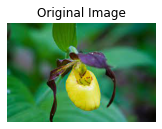

In [2]:
img =plt.imread('yellow lady-slipper.jpg'); print('Size of Original image =',img.shape)
plt.subplot(2,1,1); plt.imshow(img);
plt.title('Original Image'); plt.axis('off')

In [3]:
#손실 계산을 위한 각 층의 기여도 설정 
layer_contributions ={'mixed2':0.2, 'mixed3':0.3, 'mixed4':2.0,
                     'mixed5':1.5}


In [4]:
def preprocess_image(img):
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img =inception_v3.preprocess_input(img)
    return img 

In [5]:
def deprocess_image(x):
    if K.image_data_format() =='channels_first':
        x = x.reshape((3,x.shape[2], x.shape[3]))
        x = x.transpose((1,2,0))
    else :
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /=2.0; x+= 0.5; x*=255.0  # 밝기값을 원래대로 변경 
    x = np.clip(x, 0, 255).astype('uint8') #밝기값을 0 ~ 255 사이 정수로 변경 
    return x 
    

In [6]:
#모델과 가중치 가져오기 
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
dream = model.input # 입력영상을 모델과 연결한다. 

In [7]:
#참고할 층과 층이름의 사전을 만든다. 
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [8]:
loss = K.variable(0.) #손실 변수를 0으로 초기화한다. 
for layer_name in layer_contributions: # 개별 층들에 대해서 순서대로 
    coeff =layer_contributions[layer_name]
    x = layer_dict[layer_name].output
    scaling =K.prod(K.cast(K.shape(x), 'float32'))
    # 각 층별 기여도를 반영하는 손실값을 구하고 스케일링해서 누적 전체 손실을 구한다. 
    
    if K.image_data_format() == 'channels_first':
        loss = loss+coeff*K.sum(K.square(x[:,:,2:-2,2:-2]))/scaling
    else: 
       loss = loss+coeff*K.sum(K.square(x[:,2:-2,2:-2,:]))/scaling

In [9]:
grads = K.gradients(loss, dream)[0]
grads /=K.maximum(K.mean(K.abs(grads)), K.epsilon())

In [10]:
#손실 값과 그레디언트값을 출력으로 묶고, 출력을 입력영상에 대해 함수화한다. 
outputs =[loss, grads]
fetch_loss_and_grads = K.function([dream],outputs)


In [11]:

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

In [12]:
def resize_img(img, size):
    img =np.copy(img)
    if K.image_data_format() =='channels_first':
        factors =(1,1,float(size[0]) /img.shape[2],
                 float(size[1]) / img.shape[3])
    else:
        factors =(1,float(size[0]) / img.shape[1],
                 float(size[1]) / img.shape[2],1)
    return scipy.ndimage.zoom(img, factors, order =1)    

In [13]:
def gradient_ascent(x,iterations, step):
    for i in range(iterations):
        loss_value, grad_values =eval_loss_and_grads(x)
        x += step *grad_values
    return x 

In [14]:
step = 0.02
num_octave = 3 
octave_scale = 1.4 
iterations = 20 

In [15]:
img = preprocess_image(img); print('Size of Preprocessed image=', img.shape) 
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
print('\n Successive shapes=', successive_shapes)

Size of Preprocessed image= (1, 183, 275, 3)

 Successive shapes= [(183, 275)]


In [16]:
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
    print('Successive shapes =', successive_shapes)
successive_shapes = successive_shapes[::-1]
print('Successive shapes =', successive_shapes, '\n')

Successive shapes = [(183, 275), (130, 196)]
Successive shapes = [(183, 275), (130, 196), (93, 140)]
Successive shapes = [(93, 140), (130, 196), (183, 275)] 



In [17]:
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])
for shape in successive_shapes:
    print('===Processing image shape=', shape, "==")
    deep_dream_img = resize_img(img, shape)
    deep_dream_img = gradient_ascent(deep_dream_img,
                          iterations=iterations,
                          step=step)
    scaled_original_img = resize_img(original_img, shape)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)    
    lost_detail = scaled_original_img - upscaled_shrunk_original_img

    deep_dream_img = deep_dream_img + lost_detail
    shrunk_original_img = resize_img(original_img, shape)

===Processing image shape= (93, 140) ==
===Processing image shape= (130, 196) ==
===Processing image shape= (183, 275) ==


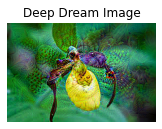

In [18]:
plt.subplot(2,1,2); plt.imshow(deprocess_image(np.copy(deep_dream_img)))
plt.title('Deep Dream Image'); plt.axis('off')
plt.savefig('savefig_default.png')